In [1]:
%pylab inline
#%matplotlib notebook
import xarray as xr
from glob import glob
import pandas as pd
#from xradd import *
from rrtmg_lw_functions import *
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from scipy.interpolate import griddata
import scipy.io
from scipy import interpolate
from netCDF4 import Dataset
degree_sign= u'\N{DEGREE SIGN}'


Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_dist(lat1,lat2,lon1,lon2):
    dlat = abs(lat1-lat2)
    dlon = abs(lon1-lon2)
    R = 6371
    a = np.sin(np.radians(dlat)/2)**2+np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.sin(np.radians(dlon)/2)**2
    c = 2*math.atan2(np.sqrt(a),np.sqrt(1-a))
    return R*c

### Read GEM data

Choose one time step: 600 min (22:00 UTC). This is a time step when the overworld water vapor plume is wide spread and the convection just passed its peak

In [3]:
#timestr = '480'
timestr = '600'
indir1 = '/storage/xwang/transfer_data/data/GEM_1p0_griddata/'
ff=xr.open_dataset(indir1+'2013082512_0'+timestr+'m_1p0_tt_theta_thetav_gz.nc')
ff0=xr.open_dataset(indir1+'2013082512_0001m_1p0_tt_theta_thetav_gz.nc')
ffw=xr.open_dataset(indir1+'2013082512_0'+timestr+'m_1p0_h2o_mix_gz.nc')
ffw0=xr.open_dataset(indir1+'2013082512_0001m_1p0_h2o_mix_gz.nc')
ff1 = xr.open_dataset(indir1+'2013082512_0'+timestr+'m_1p0_IWC_gz.nc')
ff2 = xr.open_dataset(indir1+'2013082512_0'+timestr+'m_1p0_P_rhou_gz.nc')
ff20 = xr.open_dataset(indir1+'2013082512_0001m_1p0_P_rhou_gz.nc')
ff3 = xr.open_dataset(indir1+'2013082512_0'+timestr+'m_1p0_trop_gz.nc')


In [4]:
lat1 = 45;lat2=52
lat = ff1.lat.sel(lat=slice(lat1,lat2)).data
lon=ff1.lon.data
nlat = np.size(lat)
nlon=np.size(lon)

In [5]:
wv = ffw.h2o_mix.sel(lat=slice(lat1,lat2)).data
wv0=ffw0.h2o_mix.sel(lat=slice(lat1,lat2)).data
wv_anom = wv-np.nanmean(wv0,axis=-1)[:,:,np.newaxis]
wv_anom2 = wv-np.nanmean(wv0,axis=-1)[:,:,np.newaxis]-np.nanstd(wv0,axis=-1)[:,:,np.newaxis]
#del wv0
tt=ff.tt.sel(lat=slice(lat1,lat2)).data
tt0=ff0.tt.sel(lat=slice(lat1,lat2)).data
tt_anom = tt-np.nanmean(tt0,axis=-1)[:,:,np.newaxis]
#del tt0
iwc = ff1.IWC.sel(lat=slice(lat1,lat2)).data
de = ff2.pressure.sel(lat=slice(lat1,lat2)).data
iwc = iwc/de/1000.
del de
trop = ff3.trop_gz.sel(lat=slice(lat1,lat2)).data
alt = ff2.level.data
pr=ff2.density.sel(lat=slice(lat1,lat2)).data
pr0=ff20.density.sel(lat=slice(lat1,lat2)).data


### 1. Show colocation of convective water vapor and temepratrue anomaly at 16.5 km

16.5 km
plot water vapor anomaly in color shading
plot temperature anomaly in black contour
plot temperature anomaly in color shading
plot water vapor anomaly in black contour
plot IWC in cyan contours at average tropopause altitude (14.5km)


Text(0.5, 1.0, 'Temperatrue anomaly 16.5 km')

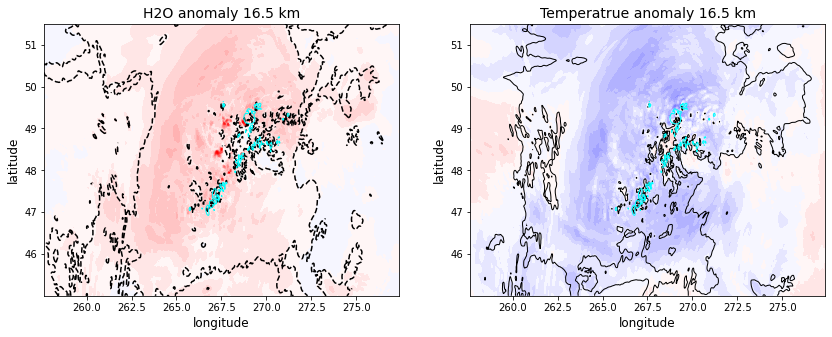

In [6]:
fig,ax = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(14,5, forward=True)
ilev=33
print(alt[ilev],'km')

print('plot water vapor anomaly in color shading')
ax[0].contourf(lon,lat,wv[ilev,:]-np.nanmean(wv0[ilev,:],axis=-1)[:,np.newaxis],\
                  cmap='bwr',levels=np.arange(-15,16,1),extend='both')

print('plot temperature anomaly in black contour')
ax[0].contour(lon,lat,tt[ilev,:]-np.nanmean(tt0[ilev,:],axis=-1)[:,np.newaxis],levels=[-1],colors='k')

print('plot temperature anomaly in color shading')
ax[1].contourf(lon,lat,tt[ilev,:]-np.nanmean(tt0[ilev,:],axis=-1)[:,np.newaxis],\
                cmap='bwr',levels=np.arange(-15,16,1),extend='both')

print('plot water vapor anomaly in black contour')
ax[1].contour(lon,lat,wv_anom2[ilev,:],levels=[0],colors='k',linewidths=1)

print('plot IWC in cyan contours at average tropopause altitude (14.5km)')
ax[0].contour(lon,lat,iwc[25,:],levels=[1e-3],colors='cyan',linewidths=1)
ax[1].contour(lon,lat,iwc[25,:],levels=[1e-3],colors='cyan',linewidths=1)

ax[0].set_ylabel('latitude',fontsize=12)
ax[0].set_xlabel('longitude',fontsize=12)
ax[1].set_ylabel('latitude',fontsize=12)
ax[1].set_xlabel('longitude',fontsize=12)
ax[0].set_title('H2O anomaly 16.5 km',fontsize=14)
ax[1].set_title('Temperatrue anomaly 16.5 km',fontsize=14)



### 2. Anomaly - radius plot

#### First get the distance matrix

In [7]:
### Set the center lat and lon (can be customized according to need)
flagi = np.zeros_like(iwc)
flagi[iwc>1e-5]=1

idx = np.where(flagi[19,:]>0)
latc = lat[idx[0]].mean()
lonc = lon[idx[1]].mean()

In [8]:
dist_mtx = np.zeros((nlat,nlon))
for i in range(nlat):
    for j in range(nlon):
        dist_mtx[i,j]=get_dist(latc,lat[i],lonc,lon[j])

##### Show the distance matrix

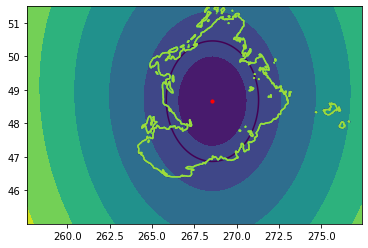

In [9]:
plt.contourf(lon,lat,dist_mtx)
plt.contour(lon,lat,dist_mtx,levels=[200])
plt.scatter(lonc,latc,s=10,color='r')
plt.contour(lon,lat,flagi[19,:])

#### Compute the averaged profiles in each radius range

In [10]:
nlev = 58 #77
ndist = 100
dist_range = np.arange(10,1010,10)

t_profile_pos = np.zeros((nlev,ndist)) ### to the east of the center
t_profile_neg = np.zeros((nlev,ndist)) ### to the west of the center

iwc_profile_pos = np.zeros((nlev,ndist))
iwc_profile_neg = np.zeros((nlev,ndist))

wv_profile_pos = np.zeros((nlev,ndist))
wv_profile_neg = np.zeros((nlev,ndist))

trop_pos = np.zeros((ndist))
trop_neg = np.zeros((ndist))

for i in range(ndist):
    idx = np.where(dist_mtx<=dist_range[i])
    ii1 = np.where(lon[idx[1]]>=lonc)[0]
    ii2 = np.where(lon[idx[1]]<=lonc)[0]
    t_profile_pos[:,i] = np.nanmean(tt_anom[:,idx[0][ii1],idx[1][ii1]],axis=-1)
    t_profile_neg[:,i] = np.nanmean(tt_anom[:,idx[0][ii2],idx[1][ii2]],axis=-1)
    iwc_profile_pos[:,i] = np.nanmean(iwc[:,idx[0][ii1],idx[1][ii1]],axis=-1)
    iwc_profile_neg[:,i] = np.nanmean(iwc[:,idx[0][ii2],idx[1][ii2]],axis=-1)
    wv_profile_pos[:,i] = np.nanmean(wv_anom2[:,idx[0][ii1],idx[1][ii1]],axis=-1)
    wv_profile_neg[:,i] = np.nanmean(wv_anom2[:,idx[0][ii2],idx[1][ii2]],axis=-1)
    trop_pos[i] = np.nanmean(trop[idx[0][ii1],idx[1][ii1]])
    trop_neg[i] = np.nanmean(trop[idx[0][ii2],idx[1][ii2]])
    
t_profile_all = np.zeros((nlev,2*ndist))
t_profile_all[:,:100]=t_profile_neg[:,::-1]*1.
t_profile_all[:,100:] = t_profile_pos*1.
i_profile_all = np.zeros((nlev,2*ndist))
i_profile_all[:,:100]=iwc_profile_neg[:,::-1]*1.
i_profile_all[:,100:] = iwc_profile_pos*1.
wv_profile_all = np.zeros((nlev,2*ndist))
wv_profile_all[:,:100]=wv_profile_neg[:,::-1]*1.
wv_profile_all[:,100:] = wv_profile_pos*1.
trop_all = np.zeros((2*ndist))
trop_all[:100]=trop_neg[::-1]*1.
trop_all[100:] = trop_pos*1.

dist_range_all = np.arange(-1000,1010,10)
dist_range_all = (dist_range_all[1:]+dist_range_all[:-1])/2.

### Show the temperature anomaly. 

It shows the convective cold top phenomenon as described in various papers:

Kim et al. (2017) (https://doi.org/10.1002/2017JD027080)

Paulik and Birner (2012) (https://doi.org/10.5194/acp-12-12183-2012)

Holloway and Neelin (2007) (https://doi.org/10.1175/JAS3907.1)

##### Conclusion: It indicates that eventhough there is a colocation of the positive water vapor anomaly and negative temperature anomaly above the convection, the seamingly convenient anti-correlation is not a causal relationship. The negative temperatrue anomaly exists due to mechanisms explained by the above literature. The positive water vapor anomaly exists due to convectvie moistening. 

##### The negative temperatrue anomaly is not a cause of the positive water vapor anomaly. vice versa.

plot temperature anomaly in color shading
plot ice contour in cyan
plot water vapor anomaly in red contour


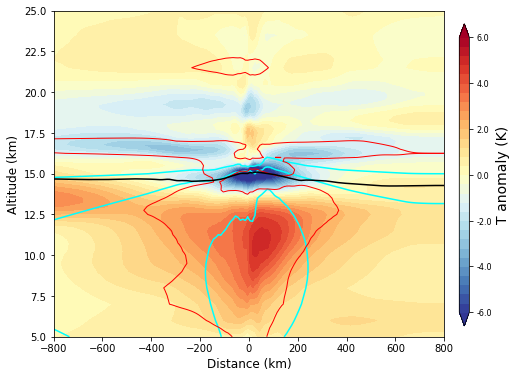

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(7,6, forward=True)
levels=np.arange(-6,6.4,0.4)

print('plot temperature anomaly in color shading')
ima=ax.contourf(dist_range_all,alt,t_profile_all,cmap='RdYlBu_r',levels=levels,extend='both')
print('plot ice contour in cyan')
ax.contour(dist_range_all,alt,i_profile_all,colors='cyan',levels=[1e-5,1e-4,1e-3])
print('plot water vapor anomaly in red contour')
ax.contour(dist_range_all,alt,wv_profile_all,colors='r',levels=[0],linewidths=1)

ax.plot(dist_range_all,trop_all,color='k')
ax.set_ylim([5,25])
ax.set_xticks(np.arange(-1000,1200,200))
ax.set_xlabel('Distance (km)',fontsize=12)
ax.set_ylabel('Altitude (km)',fontsize=12)
ax.set_xlim([-800,800])

cbaxes = fig.add_axes([0.93,0.15,0.02,0.7])                             # setup colorbar
cc = fig.colorbar(ima, ax=ax,cax=cbaxes)

cc.set_ticks(levels[::5])
clabels = np.array([str(round(i,2)) for i in levels[::5]])
cc.set_ticklabels(clabels)
cc.ax.tick_params(labelsize=8)
cc.set_label('T anomaly (K)',fontsize=14)